In [83]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import csv
import math
from xml.dom.minidom import Document
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom.minidom import parseString
import re

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.sparse import hstack

# Converting the data file to xml and then the annotated file back into csv with all the columns

In [84]:
# Function to convert DataFrame column to XML
def csv_to_xmlFile(df, columnNumb):
    root = Element('texts')
    for item in df.iloc[:, columnNumb]:
        # Check for NaN values and replace with an empty string
        if pd.isna(item):
            item = ''
        text_element = SubElement(root, 'text')
        text_element.text = item
    xml_str = parseString(tostring(root, 'utf-8')).toprettyxml(indent="  ")
    return xml_str

# Load the CSV file
file_path = 'storadatan.csv'
data = pd.read_csv(file_path, header=None, encoding='utf-8')

# Convert the second column to XML
xml_output = csv_to_xmlFile(data, 1)

# Saving the XML to a file
xml_file_path = 'storadatanXML.xml'
with open(xml_file_path, 'w', encoding='utf-8') as file:
    file.write(xml_output)

xml_file_path

'storadatanXML.xml'

In [85]:

def xml_to_csvFile(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    data = []
    paragrafnummer = 1
    
    for paragraph in root.findall('.//paragraph'):
        for sentence in paragraph.findall('.//sentence'):
            for word in sentence.findall('.//w'):
                data.append({
                    "paragrafnummer": paragrafnummer,
                    "token": word.text,
                    "msd": word.get('msd', ''),
                    "lemma": word.get('lemma', ''),
                    "lex": word.get('lex', ''),
                    "sense": word.get('sense', ''),
                    "complemgram": word.get('complemgram', ''),
                    "compwf": word.get('compwf', ''),
                    "sentimentclass": word.get('sentimentclass', ''),
                    "ref": word.get('ref', ''),
                    "dephead": word.get('dephead', ''),
                    "deprel": word.get('deprel', '')
                })
        paragrafnummer += 1  # Increment for each paragraph
    
    df = pd.DataFrame(data)
    df['dephead'] = df['dephead'].replace("", 0)
    # Convert sentimentclass values to numerical values
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1, "": ""}
    df['sentimentclass'] = df['sentimentclass'].map(sentiment_mapping)

    csv_path = xml_path.replace('.xml', '.csv')
    df.to_csv(csv_path, index=False)
    return csv_path



# Use the function
xml_path = 'storadatanBr.xml'
csv_path = xml_to_csvFile(xml_path)
print(f"CSV file created at: {csv_path}")


CSV file created at: storadatanBr.csv


- Loads and checks how the annotated data looks like

In [86]:
testtestdata_df = pd.read_csv(csv_path, encoding='utf-8')
testtestdata_df

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel
0,1,Vårens,NN.UTR.SIN.DEF.GEN,|vår|,|vår..nn.1|,|vår..1:-1.000|,|,|,0.0,1,3,DT
1,1,första,RO.NOM,|,|,|,|,|,NaN,2,3,DT
2,1,blommor,NN.UTR.PLU.IND.NOM,|blomma|,|blomma..nn.1|,|blomma..1:-1.000|,|blomma..nn.1+mor..nn.2:1.816e-11|blom..nn.1+m...,|blom+mor|,0.0,3,4,SS
3,1,har,VB.PRS.AKT,|ha|,|ha..vb.1|,|ha..3:0.504|ha..1:0.496|,|,|,0.0,4,0,ROOT
4,1,börjat,VB.SUP.AKT,|börja|,|börja..vb.1|börja..vb.2|,|börja..2:0.515|börja..1:0.485|,|,|,0.0,5,4,VG
...,...,...,...,...,...,...,...,...,...,...,...,...
28729,2001,miljöer,NN.UTR.PLU.IND.NOM,|miljö|,|miljö..nn.1|,|miljö..1:-1.000|,|,|,0.0,17,13,PA
28730,2001,!,MAD,|,|,|,|,|,NaN,18,8,IU
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT


In [87]:
testtestorg_df = pd.read_csv('storaDatan.csv', header=None, names=['sentimentannotation', 'sentence', 'category'], encoding='utf-8')
testtestorg_df

,sentimentannotation,sentence,category
0,1,Vårens första blommor har börjat blomma i träd...,egna meningar
1,1,Jag blev upplyft av det stöd jag fick från min...,egna meningar
2,1,Den nya kaffebaren i grannskapet serverar utsö...,egna meningar
3,1,Att lyssna på musik på morgonen gör mig glad h...,egna meningar
4,1,Jag är tacksam för de lugna stunderna jag får ...,egna meningar
...,...,...,...
1997,−1,"Det var det mest hiskeliga jag sett på länge ,...",Svenskt frasnät (SweFN)
1998,1,Han var duktig i matte och gillade att räkna u...,Svenskt frasnät (SweFN)
1999,1,"Skön stämning och glada miner , det gillas ska...",Svenskt frasnät (SweFN)
2000,1,En sak som jag gillar med konferenser är att d...,Svenskt frasnät (SweFN)


In [88]:
# Add sentimentval from testtestorg to testtestdata
testtestdata_df['sentimentval'] = testtestdata_df['paragrafnummer'].apply(
    lambda x: testtestorg_df.at[x-1, 'sentimentannotation'] if x-1 < len(testtestorg_df) else None
)

# Map the category from testtestorg to testtestdata
testtestdata_df['category'] = testtestdata_df['paragrafnummer'].apply(
    lambda x: testtestorg_df.at[x-1, 'category'] if x-1 < len(testtestorg_df) else None
)

# Replace âˆ’ with - in the entire DataFrame
testtestdata_df = testtestdata_df.replace('−', '-', regex=True)

# Save the final corrected DataFrame to a new CSV file
final_csv_path = 'final_corrected_testtestdata.csv'
testtestdata_df.to_csv(final_csv_path, index=False)


In [89]:
dfFin = pd.read_csv('final_corrected_testtestdata.csv', encoding='utf-8')
unique_values = dfFin['sentimentval'].unique()
print(unique_values)
dfFin = dfFin['dephead'].fillna(0)


[ 1  0 -1]


In [90]:
dfFin = pd.read_csv('final_corrected_testtestdata.csv', encoding='utf-8')
dfFin.tail(3)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar
28733,2002,adventsstjärna,NN.UTR.SIN.IND.NOM,|adventsstjärna|,|adventsstjärna..nn.1|,|adventsstjärna..1:-1.000|,|advent..nn.1+stjärna..nn.1:2.951e-13|,|advents+stjärna|,NaN,3,0,ROOT,1,egna meningar


# Rule-based base model

In [91]:
def round_half_up(n, decimals=0):
    multiplier = 10**decimals
    if(multiplier >= 0):
        return math.floor(n * multiplier + 0.5) / multiplier
    else:
        return math.ceil(n * multiplier + 0.5) / multiplier

In [92]:
def round_up(x):
    if x >= 0.2:
        return 1
    else:
        if x <= (-0.2) :
            return -1
        else:
            return 0

In [93]:
round_up(0.6)

1

In [94]:
def normalize(score, alpha=15):
    # Normalizes the score to be between -1 and 1 using an alpha that approximates the max expected value

    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score

In [95]:
def add_calculated_sentiment_column(df, group_column, value_column, normalized_column_name='average_sentiment'):

    # Add a column to the DataFrame containing the normalized sentiment value of the specified column grouped by the other column
    # df: DataFrame to be modified
    # group_column: Name of the column to group by
    # value_column: Name of the column whose sentiment will be normalized
    # normalized_column_name: The name for the new column containing the normalized sentiment values
    # Returns a DataFrame with the new column added

    # Group by group_column and calculate the sum of value_column then apply normalization
    sentiment_sums = df.groupby(group_column)[value_column].sum().reset_index()
    sentiment_sums[value_column] = sentiment_sums[value_column].apply(normalize)
    sentiment_sums[value_column] = sentiment_sums[value_column].apply(round_up)
    
    # Merge the normalized sentiment values back into the original DataFrame
    df = df.merge(sentiment_sums, on=group_column, suffixes=('', '_norm'))
    
    # Rename the columns for clarity
    df.rename(columns={value_column + '_norm': normalized_column_name}, inplace=True)
    
    return df

# Usage
predictDf = pd.read_csv('final_corrected_testtestdata.csv', encoding='utf-8')
predictDf = add_calculated_sentiment_column(predictDf, 'paragrafnummer', 'sentimentclass')
predictDf.tail(5)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
28729,2001,miljöer,NN.UTR.PLU.IND.NOM,|miljö|,|miljö..nn.1|,|miljö..1:-1.000|,|,|,0.0,17,13,PA,1,Svenskt frasnät (SweFN),1
28730,2001,!,MAD,|,|,|,|,|,NaN,18,8,IU,1,Svenskt frasnät (SweFN),1
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar,1
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar,1
28733,2002,adventsstjärna,NN.UTR.SIN.IND.NOM,|adventsstjärna|,|adventsstjärna..nn.1|,|adventsstjärna..1:-1.000|,|advent..nn.1+stjärna..nn.1:2.951e-13|,|advents+stjärna|,NaN,3,0,ROOT,1,egna meningar,1


# Negation handling

In [96]:
lista_negationer = ["inte", "ej", "icke", "ingen", "inget", "inga", "knappast", "aldrig", "ingenting", "ingenstans", "sällan", "varken", "nej", "trots"]

In [97]:
def negation_score_optimized(dataF, negList):
    # For a sentence find the negation words and do invertions of the connected words to it in the hierarchy
    # Create a copy of the DataFrame to not modify the original accidentally
    result = dataF.copy()
    
    # Find indices of negation words
    neg_indices = result[result['token'].isin(negList)].index
    
    for neg_index in neg_indices:
        dep_head = result.at[neg_index, 'dephead']
        
        # Find all nodes that are dependent on this negation word
        dependent_indices = result[result['ref'] == dep_head].index
        
        # Negate sentiment class for all dependent nodes and their children
        for dependent_index in dependent_indices:
            child_indices = result[result['dephead'] == result.at[dependent_index, 'ref']].index
            # Negate sentiment class for the dependent node
            result.loc[dependent_index, 'sentimentclass'] *= -1
            # Negate sentiment class for all child nodes
            result.loc[child_indices, 'sentimentclass'] *= -1
        
        #print(f"Found negation word '{result.at[neg_index, 'token']}' in row {neg_index}")

    return result

testingtest = pd.read_csv('final_corrected_testtestdata.csv', encoding='utf-8')
testingtest[testingtest['paragrafnummer'] == 1038]


,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category
15035,1038,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,-1,egna meningar
15036,1038,gillar,VB.PRS.AKT,|gilla|,|gilla..vb.1|,|gilla..1:0.992|gilla..2:0.008|,|,|,1.0,2,0,ROOT,-1,egna meningar
15037,1038,verkligen,AB,|verkligen|,|verkligen..ab.1|,|verkligen..1:-1.000|,|,|,NaN,3,2,MA,-1,egna meningar
15038,1038,inte,AB,|inte|,|inte..ab.1|,|inte..1:-1.000|,|,|,NaN,4,2,NaN,-1,egna meningar
15039,1038,denna,DT.UTR.SIN.DEF,|denna|,|denna..pn.1|,|denna..1:-1.000|,|,|,NaN,5,6,DT,-1,egna meningar
15040,1038,appen,NN.UTR.SIN.DEF.NOM,|app|,|app..nn.1|,|app..1:-1.000|,|app..nn.1+pen..nn.1:6.737e-12|apa..nn.1+pen.....,|app+pen|ap+pen|,NaN,6,2,OO,-1,egna meningar
15041,1038,.,MAD,|,|,|,|,|,NaN,7,2,IP,-1,egna meningar


In [98]:
# Apply negation handling to each paragraph group in the DataFrame
def apply_negation_by_paragraph(df, negList):
    # Apply the negation score function to each group and combine the results
    result_df = df.groupby('paragrafnummer', group_keys=False).apply(negation_score_optimized, negList=negList)
    return result_df

tttt = apply_negation_by_paragraph(testingtest, lista_negationer)

In [99]:
# Checking that it negated the word "inte"
tttt[tttt['paragrafnummer'] == 1038]

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category
15035,1038,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,-1,egna meningar
15036,1038,gillar,VB.PRS.AKT,|gilla|,|gilla..vb.1|,|gilla..1:0.992|gilla..2:0.008|,|,|,-1.0,2,0,ROOT,-1,egna meningar
15037,1038,verkligen,AB,|verkligen|,|verkligen..ab.1|,|verkligen..1:-1.000|,|,|,NaN,3,2,MA,-1,egna meningar
15038,1038,inte,AB,|inte|,|inte..ab.1|,|inte..1:-1.000|,|,|,NaN,4,2,NaN,-1,egna meningar
15039,1038,denna,DT.UTR.SIN.DEF,|denna|,|denna..pn.1|,|denna..1:-1.000|,|,|,NaN,5,6,DT,-1,egna meningar
15040,1038,appen,NN.UTR.SIN.DEF.NOM,|app|,|app..nn.1|,|app..1:-1.000|,|app..nn.1+pen..nn.1:6.737e-12|apa..nn.1+pen.....,|app+pen|ap+pen|,NaN,6,2,OO,-1,egna meningar
15041,1038,.,MAD,|,|,|,|,|,NaN,7,2,IP,-1,egna meningar


In [100]:
# Adding the calculated sentiment column to thre dataframe
ttttPred = add_calculated_sentiment_column(tttt, 'paragrafnummer', 'sentimentclass')
ttttPred.tail(3)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar,1
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar,1
28733,2002,adventsstjärna,NN.UTR.SIN.IND.NOM,|adventsstjärna|,|adventsstjärna..nn.1|,|adventsstjärna..1:-1.000|,|advent..nn.1+stjärna..nn.1:2.951e-13|,|advents+stjärna|,NaN,3,0,ROOT,1,egna meningar,1


# Testing base and negation handling models

In [101]:
def test_compare(df):
    # Group the DataFrame by paragrafnummer and calculate the average sentiment scores for each group
    grouped_means = df.groupby('paragrafnummer').agg({'average_sentiment': 'mean', 'sentimentval': 'mean'})
    
    # Calculate the absolute difference between predicted and real values
    grouped_means['abs_diff'] = abs(grouped_means['average_sentiment'] - grouped_means['sentimentval'])
    
    # Calculate the test accuracy: 1 minus average absolute difference
    test_accuracy = 1 - grouped_means['abs_diff'].mean()
    
    print("Test Accuracy:", test_accuracy)
    
test_compare(ttttPred) # With negation handling
ttttPred2 = add_calculated_sentiment_column(testingtest, 'paragrafnummer', 'sentimentclass')
test_compare(ttttPred2) # Without negation handling

Test Accuracy: 0.4785214785214785
Test Accuracy: 0.4285714285714286


In [102]:
#ttttPred.to_csv('semModRes.csv', index=False)

In [103]:
def test_comparePerClass(df):
    # Group the DataFrame by paragrafnummer and calculate the average sentiment scores for each group
    grouped_means = df.groupby('paragrafnummer').agg({'average_sentiment': 'mean', 'sentimentval': 'mean'})
    
    # Calculate the absolute difference between predicted and real values
    grouped_means['abs_diff'] = abs(grouped_means['average_sentiment'] - grouped_means['sentimentval'])
    
    # Calculate the test accuracy: 1 minus average absolute difference
    test_accuracy = 1 - grouped_means['abs_diff'].mean()
    
    print("Test Accuracy:", test_accuracy)
    
    # Calculate accuracy for each class
    classes = df['sentimentval'].unique()
    for cls in classes:
        class_df = df[df['sentimentval'] == cls]
        class_grouped_means = class_df.groupby('paragrafnummer').agg({'average_sentiment': 'mean', 'sentimentval': 'mean'})
        class_grouped_means['abs_diff'] = abs(class_grouped_means['average_sentiment'] - class_grouped_means['sentimentval'])
        class_accuracy = 1 - class_grouped_means['abs_diff'].mean()
        print("Class", cls, "Accuracy:", class_accuracy)

# Calling the function with the DataFrame
test_comparePerClass(ttttPred) # With negation handling
ttttPred2 = add_calculated_sentiment_column(testingtest, 'paragrafnummer', 'sentimentclass')
test_comparePerClass(ttttPred2) # Without negation handling

Test Accuracy: 0.4785214785214785
Class 1 Accuracy: 0.7080838323353293
Class 0 Accuracy: 0.47976011994003
Class -1 Accuracy: 0.24737631184407793
Test Accuracy: 0.4285714285714286
Class 1 Accuracy: 0.7125748502994012
Class 0 Accuracy: 0.4782608695652174
Class -1 Accuracy: 0.09445277361319337


Test Accuracy: 0.4785214785214785
Precision (weighted): 0.5995853537742483
Recall (weighted): 0.5704295704295704
F1 Score (weighted): 0.5666222013544799


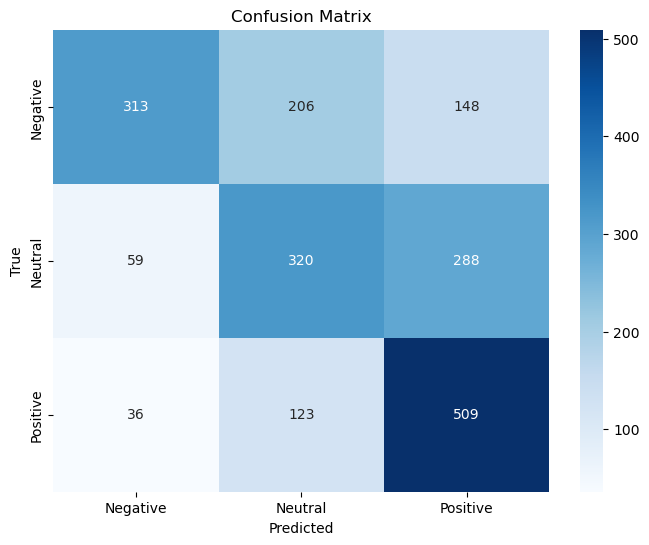

Test Accuracy: 0.4285714285714286
Precision (weighted): 0.588968467720289
Recall (weighted): 0.5474525474525475
F1 Score (weighted): 0.5400007537873904


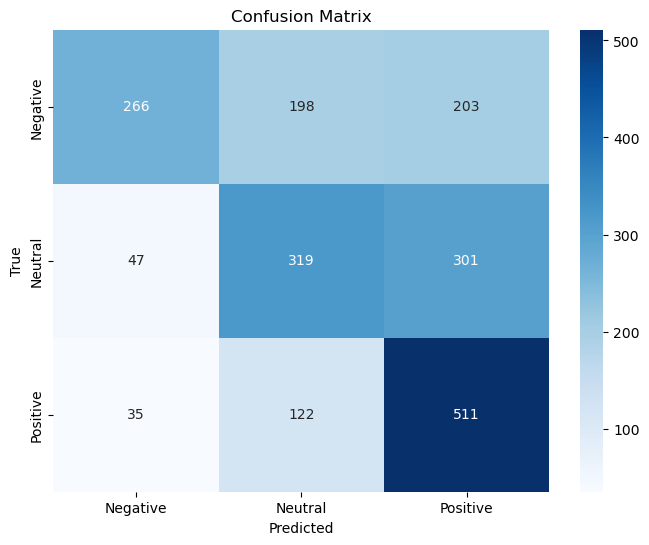

In [104]:
def test_compareplot(df):
    # Group the DataFrame by paragrafnummer and calculate the average sentiment scores for each group
    grouped_means = df.groupby('paragrafnummer').agg({'average_sentiment': 'mean', 'sentimentval': 'first'})
    
    # Calculate the test accuracy: 1 minus average absolute difference
    test_accuracy = 1 - abs(grouped_means['average_sentiment'] - grouped_means['sentimentval']).mean()
    
    print("Test Accuracy:", test_accuracy)
    
    # Calculate precision, recall, and F1 scores for all classes
    y_true = grouped_means['sentimentval']
    y_pred = grouped_means['average_sentiment']
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("Precision (weighted):", precision)
    print("Recall (weighted):", recall)
    print("F1 Score (weighted):", f1)
    
    # Plot a confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Calling the function with the DataFrame
test_compareplot(ttttPred) # With negation handling
ttttPred2 = add_calculated_sentiment_column(testingtest, 'paragrafnummer', 'sentimentclass')
test_compareplot(ttttPred2) # Without negation handling

# Expansion

In [105]:
def extract_word_with_highest_probability(sense_string):
    # Check if the input string is empty
    if sense_string == "|":
        #print("empty")
        return None
    
    # Extract words and probabilities from the sense string
    words_and_probabilities = re.findall(r'(\w+\.\.\d+):-?(\d+\.\d+)', sense_string)
    #print(words_and_probabilities, sense_string)

    
    # Check if any words and probabilities are found
    if not words_and_probabilities:
        #print("no probs")
        return None
    
    # Sort the list of words and probabilities by probability in descending order
    sorted_words_and_probabilities = sorted(words_and_probabilities, key=lambda x: float(x[1]), reverse=True)
    #print(sorted_words_and_probabilities)
    
    # Return the word with the highest probability
    return sorted_words_and_probabilities[0][0]

In [106]:
reett = extract_word_with_highest_probability("|adventsstjärna..1:-1.000|")
print(reett)

adventsstjärna..1


In [107]:
extract_word_with_highest_probability("|förlägga..3:0.880|förlägga..1:0.064|förlägga...2:0.001")

'förlägga..3'

In [108]:
def replace_nan_with_lexicon_label(dataframe, lexicon):
    counter = 0
    # Iterate over each row in the dataframe
    for index, row in dataframe.iterrows():
        # Check if the value in the "sentimentclass" column is NaN
        if pd.isna(row['sentimentclass']):
            sense_string = row['sense']
            # Extract the word with the highest probability
            word = extract_word_with_highest_probability(sense_string)
            if counter < 10:
                #print(word)
                counter += 1

            # Check if a word is extracted and it exists in the lexicon
            if word and word in lexicon['SALDO sense ID'].values:
                # Find the corresponding label in the lexicon
                label = lexicon.loc[lexicon['SALDO sense ID'] == word, 'polarity label'].values[0]
                # Replace NaN value with the label
                dataframe.at[index, 'sentimentclass'] = label
    return dataframe

# Usage
lexicon = pd.read_csv('expandedSensaldoSorted.csv', encoding='utf-8')
dataframe = ttttPred.copy()

# Replace NaN values in the "sentimentclass" column with labels from lexicon
updated_dataframe = replace_nan_with_lexicon_label(dataframe, lexicon)

In [109]:
def count_nan_sentimentclass(dataframe):
    # Count the number of NaN values in the "sentimentclass" column
    nan_count = dataframe['sentimentclass'].isna().sum()
    return nan_count

In [110]:
ttttPred.tail(3)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar,1
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar,1
28733,2002,adventsstjärna,NN.UTR.SIN.IND.NOM,|adventsstjärna|,|adventsstjärna..nn.1|,|adventsstjärna..1:-1.000|,|advent..nn.1+stjärna..nn.1:2.951e-13|,|advents+stjärna|,NaN,3,0,ROOT,1,egna meningar,1


In [111]:
# Now "adventsstjärna"'s sentiment annotation is added from the lexicon
updated_dataframe.tail(3)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar,1
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar,1
28733,2002,adventsstjärna,NN.UTR.SIN.IND.NOM,|adventsstjärna|,|adventsstjärna..nn.1|,|adventsstjärna..1:-1.000|,|advent..nn.1+stjärna..nn.1:2.951e-13|,|advents+stjärna|,1.0,3,0,ROOT,1,egna meningar,1


In [112]:
count_nan_sentimentclass(ttttPred)

18391

In [113]:
# A decrease in the number of NaNs present in the dataframe
count_nan_sentimentclass(updated_dataframe)

16626

# Applying the expansion with and without negation handling

In [114]:
dForExpanded = pd.read_csv('final_corrected_testtestdata.csv', encoding='utf-8')
dForExpanded

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category
0,1,Vårens,NN.UTR.SIN.DEF.GEN,|vår|,|vår..nn.1|,|vår..1:-1.000|,|,|,0.0,1,3,DT,1,egna meningar
1,1,första,RO.NOM,|,|,|,|,|,NaN,2,3,DT,1,egna meningar
2,1,blommor,NN.UTR.PLU.IND.NOM,|blomma|,|blomma..nn.1|,|blomma..1:-1.000|,|blomma..nn.1+mor..nn.2:1.816e-11|blom..nn.1+m...,|blom+mor|,0.0,3,4,SS,1,egna meningar
3,1,har,VB.PRS.AKT,|ha|,|ha..vb.1|,|ha..3:0.504|ha..1:0.496|,|,|,0.0,4,0,ROOT,1,egna meningar
4,1,börjat,VB.SUP.AKT,|börja|,|börja..vb.1|börja..vb.2|,|börja..2:0.515|börja..1:0.485|,|,|,0.0,5,4,VG,1,egna meningar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28729,2001,miljöer,NN.UTR.PLU.IND.NOM,|miljö|,|miljö..nn.1|,|miljö..1:-1.000|,|,|,0.0,17,13,PA,1,Svenskt frasnät (SweFN)
28730,2001,!,MAD,|,|,|,|,|,NaN,18,8,IU,1,Svenskt frasnät (SweFN)
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar


In [115]:
# Replace NaN values in the "sentimentclass" column with labels from lexicon
dForExpanded = replace_nan_with_lexicon_label(dForExpanded, lexicon)

In [116]:
dForExpandedNeg = dForExpanded.copy()

In [117]:
dForExpandedNeg = apply_negation_by_paragraph(dForExpandedNeg, lista_negationer)

In [118]:
dForExpanded = add_calculated_sentiment_column(dForExpanded, 'paragrafnummer', 'sentimentclass')

In [119]:
dForExpandedNeg = add_calculated_sentiment_column(dForExpandedNeg, 'paragrafnummer', 'sentimentclass')

In [120]:
dForExpandedNeg[dForExpandedNeg['paragrafnummer'] == 1038]

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
15035,1038,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,-1,egna meningar,-1
15036,1038,gillar,VB.PRS.AKT,|gilla|,|gilla..vb.1|,|gilla..1:0.992|gilla..2:0.008|,|,|,-1.0,2,0,ROOT,-1,egna meningar,-1
15037,1038,verkligen,AB,|verkligen|,|verkligen..ab.1|,|verkligen..1:-1.000|,|,|,NaN,3,2,MA,-1,egna meningar,-1
15038,1038,inte,AB,|inte|,|inte..ab.1|,|inte..1:-1.000|,|,|,NaN,4,2,NaN,-1,egna meningar,-1
15039,1038,denna,DT.UTR.SIN.DEF,|denna|,|denna..pn.1|,|denna..1:-1.000|,|,|,NaN,5,6,DT,-1,egna meningar,-1
15040,1038,appen,NN.UTR.SIN.DEF.NOM,|app|,|app..nn.1|,|app..1:-1.000|,|app..nn.1+pen..nn.1:6.737e-12|apa..nn.1+pen.....,|app+pen|ap+pen|,-0.0,6,2,OO,-1,egna meningar,-1
15041,1038,.,MAD,|,|,|,|,|,NaN,7,2,IP,-1,egna meningar,-1


# Testing the expansion with and without negation handling

In [121]:
test_compare(dForExpanded)

Test Accuracy: 0.4225774225774226


In [122]:
test_compare(dForExpandedNeg)

Test Accuracy: 0.478021978021978


In [123]:
test_comparePerClass(dForExpanded)
test_comparePerClass(dForExpandedNeg)

Test Accuracy: 0.4225774225774226
Class 1 Accuracy: 0.7095808383233533
Class 0 Accuracy: 0.4287856071964018
Class -1 Accuracy: 0.1289355322338831
Test Accuracy: 0.478021978021978
Class 1 Accuracy: 0.7065868263473054
Class 0 Accuracy: 0.43328335832083953
Class -1 Accuracy: 0.2938530734632684


Test Accuracy: 0.4225774225774226
Precision (weighted): 0.5786244413202869
Recall (weighted): 0.5444555444555444
F1 Score (weighted): 0.5373904493340228


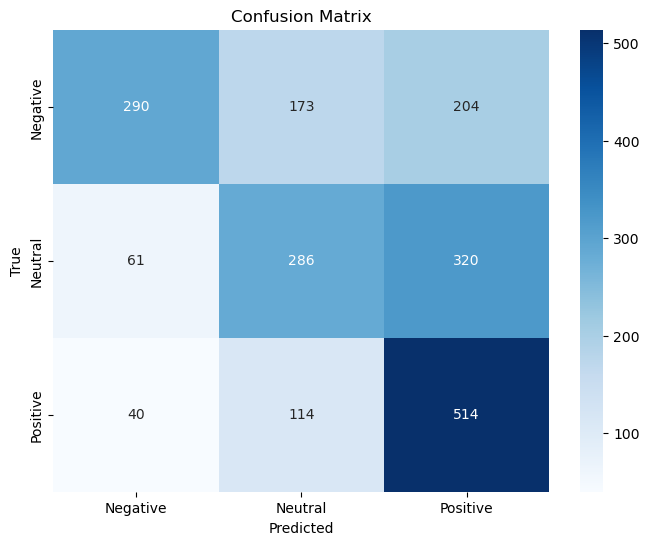

Test Accuracy: 0.478021978021978
Precision (weighted): 0.5930648133731853
Recall (weighted): 0.570929070929071
F1 Score (weighted): 0.5665807024680045


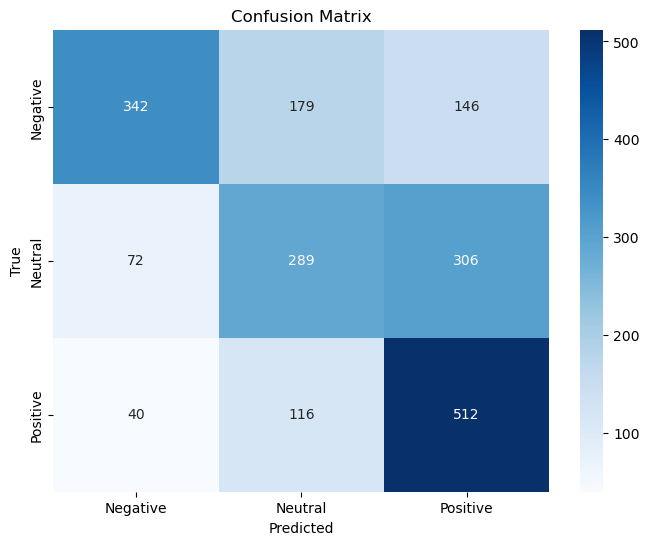

In [124]:
test_compareplot(dForExpanded)
test_compareplot(dForExpandedNeg)

# Viewing BERT results

In [125]:
def test_compareBert(df):
    # Group the DataFrame by paragrafnummer and calculate the average sentiment scores for each group
    grouped_means = df.groupby('paragrafnummer').agg({'label': 'mean', 'sentimentval': 'mean'})
    
    # Calculate the absolute difference between predicted and real values
    grouped_means['abs_diff'] = abs(grouped_means['label'] - grouped_means['sentimentval'])
    
    # Calculate the test accuracy: 1 minus average absolute difference
    test_accuracy = 1 - grouped_means['abs_diff'].mean()
    
    print("Test Accuracy:", test_accuracy)

In [126]:
resultsBERTDF = pd.read_csv('resultsBERT.csv', encoding="utf-8")
test_compareBert(resultsBERTDF)

Test Accuracy: 0.7965116279069767


Test Accuracy: 0.4785214785214785
Precision (weighted): 0.5995853537742483
Recall (weighted): 0.5704295704295704
F1 Score (weighted): 0.5666222013544799


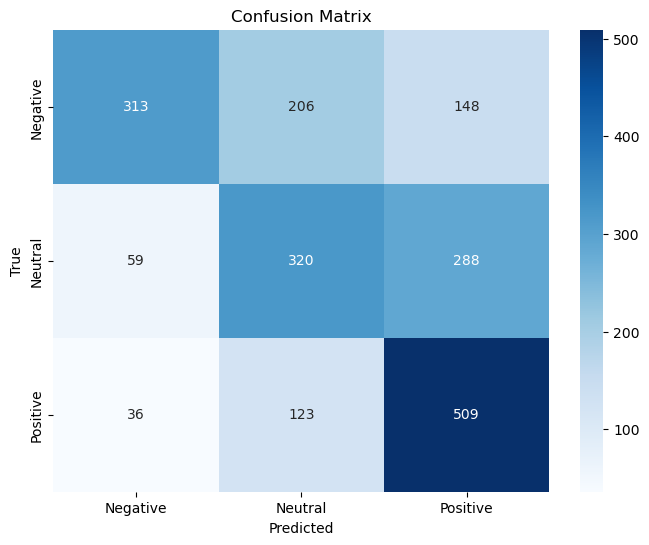

In [127]:
test_compareplot(ttttPred) # Wanted to view it before the expansion to see the difference

Test Accuracy: 0.478021978021978
Precision (weighted): 0.5930648133731853
Recall (weighted): 0.570929070929071
F1 Score (weighted): 0.5665807024680045


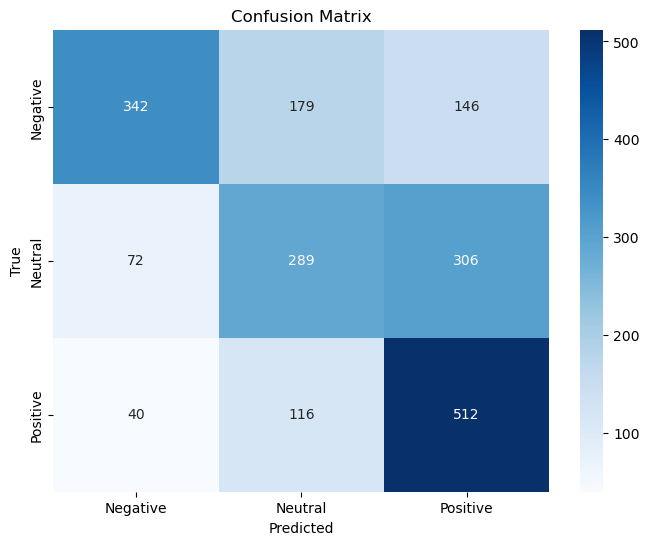

In [128]:
test_compareplot(dForExpandedNeg)

# Just some statistics and result examination

We want to see how the expansion impacted the results compared to before the expansion

In [129]:
# Filter rows where the values in the column "average_sentiment" are different
different_rows = ttttPred[ttttPred['average_sentiment'] != dForExpandedNeg['average_sentiment']]

In [130]:
different_rows

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
143,15,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,0,egna meningar,0
144,15,har,VB.PRS.AKT,|ha|,|ha..vb.1|,|ha..1:0.848|ha..3:0.152|,|,|,0.0,2,0,ROOT,0,egna meningar,0
145,15,planerat,VB.SUP.AKT,|planera|,|planera..vb.1|,|planera..1:-1.000|,|,|,0.0,3,2,VG,0,egna meningar,0
146,15,att,IE,|att|,|att..sn.1|,|att..1:-1.000|,|,|,NaN,4,3,OO,0,egna meningar,0
147,15,städa,VB.INF.AKT,|städa|,|städa..vb.1|,|städa..1:-1.000|,|,|,NaN,5,4,IF,0,egna meningar,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28677,1998,sättet,NN.NEU.SIN.DEF.NOM,|sätt|,|sätt..nn.1|,|sätt..1:-1.000|,|,|,0.0,25,22,PA,-1,Svenskt frasnät (SweFN),1
28678,1998,som,HP.-.-.-,|,|,|,|,|,NaN,26,28,OO,-1,Svenskt frasnät (SweFN),1
28679,1998,jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,27,28,SS,-1,Svenskt frasnät (SweFN),1
28680,1998,gillar,VB.PRS.AKT,|gilla|,|gilla..vb.1|,|gilla..1:0.975|gilla..2:0.025|,|,|,1.0,28,25,ET,-1,Svenskt frasnät (SweFN),1


In [131]:
# Merge different_rows with dForExpandedNeg on index
merged_df = pd.merge(different_rows, dForExpandedNeg[['sentimentclass', 'average_sentiment']], left_index=True, right_index=True, suffixes=('_ttttPred', '_dForExpandedNeg'))

In [132]:
merged_df.head(35)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass_ttttPred,ref,dephead,deprel,sentimentval,category,average_sentiment_ttttPred,sentimentclass_dForExpandedNeg,average_sentiment_dForExpandedNeg
143,15,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,0,egna meningar,0,NaN,1
144,15,har,VB.PRS.AKT,|ha|,|ha..vb.1|,|ha..1:0.848|ha..3:0.152|,|,|,0.0,2,0,ROOT,0,egna meningar,0,0.0,1
145,15,planerat,VB.SUP.AKT,|planera|,|planera..vb.1|,|planera..1:-1.000|,|,|,0.0,3,2,VG,0,egna meningar,0,0.0,1
146,15,att,IE,|att|,|att..sn.1|,|att..1:-1.000|,|,|,NaN,4,3,OO,0,egna meningar,0,NaN,1
147,15,städa,VB.INF.AKT,|städa|,|städa..vb.1|,|städa..1:-1.000|,|,|,NaN,5,4,IF,0,egna meningar,0,1.0,1
148,15,mitt,PS.NEU.SIN.DEF,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,6,7,DT,0,egna meningar,0,NaN,1
149,15,rum,NN.NEU.SIN.IND.NOM,|rum|,|rum..nn.1|,|rum..1:0.845|rum..3:0.144|rum..4:0.011|,|,|,0.0,7,5,IO,0,egna meningar,0,0.0,1
150,15,denna,DT.UTR.SIN.DEF,|denna|,|denna..pn.1|,|denna..1:-1.000|,|,|,NaN,8,9,DT,0,egna meningar,0,NaN,1
151,15,eftermiddag,NN.UTR.SIN.IND.NOM,|eftermiddag|,|eftermiddag..nn.1|,|eftermiddag..1:-1.000|,|efter..av.1+middag..nn.1:1.949e-19|,|efter+middag|,0.0,9,5,OO,0,egna meningar,0,0.0,1
152,15,.,MAD,|,|,|,|,|,NaN,10,2,IP,0,egna meningar,0,NaN,1


In [133]:
filtered_df = ttttPred[(ttttPred['sentimentval'] == -1) & (ttttPred['average_sentiment'] != -1)]
filtered_df

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
206,21,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,-1,egna meningar,0
207,21,glömde,VB.PRT.AKT,|glömma|,|glömma..vb.1|,|glömma..1:0.982|glömma..2:0.018|,|,|,0.0,2,5,MS,-1,egna meningar,0
208,21,mitt,AB,|mitt|,|mitt..ab.1|,|mitt..1:-1.000|,|,|,NaN,3,2,AA,-1,egna meningar,0
209,21,lösenord,NN.NEU.PLU.IND.NOM,|lösenord|,|lösenord..nn.1|,|lösenord..1:-1.000|,|,|,NaN,4,2,OO,-1,egna meningar,0
210,21,och,KN,|och|,|och..kn.1|,|och..1:-1.000|,|,|,NaN,5,0,ROOT,-1,egna meningar,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28677,1998,sättet,NN.NEU.SIN.DEF.NOM,|sätt|,|sätt..nn.1|,|sätt..1:-1.000|,|,|,0.0,25,22,PA,-1,Svenskt frasnät (SweFN),1
28678,1998,som,HP.-.-.-,|,|,|,|,|,NaN,26,28,OO,-1,Svenskt frasnät (SweFN),1
28679,1998,jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,27,28,SS,-1,Svenskt frasnät (SweFN),1
28680,1998,gillar,VB.PRS.AKT,|gilla|,|gilla..vb.1|,|gilla..1:0.975|gilla..2:0.025|,|,|,1.0,28,25,ET,-1,Svenskt frasnät (SweFN),1


In [134]:
filtered_df.iloc[20:55]

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
226,23,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,-1,egna meningar,0
227,23,är,VB.PRS.AKT,|vara|,|vara..vb.1|,|vara..1:-1.000|,|,|,0.0,2,6,MS,-1,egna meningar,0
228,23,allergisk,JJ.POS.UTR.SIN.IND.NOM,|allergisk|,|allergisk..av.1|,|allergisk..1:0.992|allergisk..2:0.008|,|,|,-1.0,3,2,SP,-1,egna meningar,0
229,23,mot,PP,|mot|,|mot..pp.1|,|mot..1:-1.000|mot..2:-1.000|,|,|,NaN,4,2,OA,-1,egna meningar,0
230,23,nötter,NN.UTR.PLU.IND.NOM,|nöt|,|nöt..nn.1|,|nöt..1:-1.000|,|,|,0.0,5,4,PA,-1,egna meningar,0
231,23,och,KN,|och|,|och..kn.1|,|och..1:-1.000|,|,|,NaN,6,0,ROOT,-1,egna meningar,0
232,23,måste,VB.PRS.AKT,|måste|,|måste..vb.1|,|måste..1:-1.000|,|,|,0.0,7,6,+F,-1,egna meningar,0
233,23,vara,VB.INF.AKT,|vara|,|vara..vb.1|vara..vb.2|,|vara..2:0.481|vara..1:0.370|vara..3:0.149|,|,|,0.0,8,7,VG,-1,egna meningar,0
234,23,försiktig,JJ.POS.UTR.SIN.IND.NOM,|försiktig|,|försiktig..av.1|,|försiktig..1:-1.000|,|föra..vb.1+siktig..av.1:5.518e-16|för..nn.1+s...,|för+siktig|,1.0,9,8,SP,-1,egna meningar,0
235,23,med,PP,|med|,|med..pp.1|,|med..1:-1.000|med..2:-1.000|,|,|,NaN,10,8,OA,-1,egna meningar,0


In [135]:
dForExpandedNeg[dForExpandedNeg['paragrafnummer'] == 28]

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
277,28,Jag,PN.UTR.SIN.DEF.SUB,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,1,2,SS,-1,egna meningar,-1
278,28,hittade,VB.PRT.AKT,|hitta|,|hitta..vb.1|,|hitta..1:-1.000|,|,|,0.0,2,0,ROOT,-1,egna meningar,-1
279,28,en,DT.UTR.SIN.IND,|en|,|en..al.1|,|den..1:-1.000|en..2:-1.000|,|,|,NaN,3,4,DT,-1,egna meningar,-1
280,28,spricka,NN.UTR.SIN.IND.NOM,|spricka|,|spricka..nn.1|,|spricka..2:-1.000|,|,|,-1.0,4,2,OO,-1,egna meningar,-1
281,28,i,PP,|i|,|i..pp.1|,|i..2:-1.000|,|,|,NaN,5,2,RA,-1,egna meningar,-1
282,28,min,PS.UTR.SIN.DEF,|jag|,|jag..pn.1|,|jag..1:-1.000|,|,|,NaN,6,7,DT,-1,egna meningar,-1
283,28,mobilskärm,NN.UTR.SIN.IND.NOM,|mobilskärm|,|,|,|mobil..av.1+skärm..nn.1:9.043e-12|mobil..nn.1...,|mobil+skärm|mo+bil+skärm|,NaN,7,5,PA,-1,egna meningar,-1
284,28,idag,AB,|idag|,|idag..ab.1|,|i_dag..1:-1.000|i_dag..2:-1.000|,|,|,NaN,8,2,TA,-1,egna meningar,-1
285,28,.,MAD,|,|,|,|,|,NaN,9,2,IP,-1,egna meningar,-1


In [136]:
filteredFrekvNeg = ttttPred[ttttPred['sentimentval'] != ttttPred['average_sentiment']]

In [137]:
# Group by paragrafnummer and count the number of groups
grouped_df = filteredFrekvNeg.groupby('paragrafnummer').size().reset_index(name='group_count')

# Number of groups
num_groups = grouped_df.shape[0]
print("Number of groups:", num_groups)

Number of groups: 860


In [138]:
# Randomly sample 300 groups
sampled_groups = grouped_df.sample(n=100, random_state=42)

# Ungroup the sampled groups
frekvNeg = pd.merge(sampled_groups, filtered_df, on='paragrafnummer', how='inner')

In [139]:
# Save the ungrouped DataFrame to a CSV file
frekvNeg.to_csv('frekvNeg.csv', index=False)

In [140]:
frekvNeg

,paragrafnummer,group_count,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
0,1644,11,En,DT.UTR.SIN.IND,|en|,|en..al.1|,|den..1:-1.000|en..2:-1.000|,|,|,NaN,1,2,DT,-1,Flashback: Politik,1
1,1644,11,skattesubvention,NN.UTR.SIN.IND.NOM,|skattesubvention|,|skattesubvention..nn.1|,|skattesubvention..1:-1.000|,|skatt..nn.1+subvention..nn.1:8.806e-14|,|skatte+subvention|,NaN,2,6,SS,-1,Flashback: Politik,1
2,1644,11,av,PP,|av|,|av..pp.1|,|av..1:-1.000|,|,|,NaN,3,2,ET,-1,Flashback: Politik,1
3,1644,11,hushållsnära,JJ.POS.UTR+NEU.PLU.IND+DEF.NOM,|hushållsnära|hushållsnära tjänst|,|hushållsnära..av.1|hushållsnära_tjänst..nnm.1|,|hushållsnära..1:-1.000|hushållsnära_tjänster....,|hushåll..nn.1+nära..av.1:9.862e-13|hus..nn.1+...,|hushålls+nära|hus+hålls+nära|,NaN,4,5,AT,-1,Flashback: Politik,1
4,1644,11,tjänster,NN.UTR.PLU.IND.NOM,|tjänst|hushållsnära tjänst:04|,|tjänst..nn.1|tjänst..nn.2|hushållsnära_tjänst...,|tjänst..3:0.979|tjänst..1:0.018|tjänst..2:0.0...,|,|,1.0,5,3,PA,-1,Flashback: Politik,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,1138,25,säkra,JJ.POS.UTR+NEU.PLU.IND+DEF.NOM,|säker|,|säker..av.1|,|säker..1:0.573|säker..2:0.315|säker..3:0.112|,|,|,1.0,21,22,AT,-1,SVT Nyheter 1018,0
810,1138,25,identiteter,NN.UTR.PLU.IND.NOM,|identitet|,|identitet..nn.1|,|identitet..1:-1.000|,|id..nn.3+entitet..nn.1:3.217e-13|id..nn.1+ent...,|id+entiteter|id+entit+eter|,0.0,22,20,OO,-1,SVT Nyheter 1018,0
811,1138,25,på,PP,|på|,|på..pp.1|,|på..1:-1.000|,|,|,NaN,23,20,RA,-1,SVT Nyheter 1018,0
812,1138,25,internet,NN.NEU.SIN.IND.NOM,|internet|,|internet..nn.1|,|internet..1:-1.000|,|,|,0.0,24,23,PA,-1,SVT Nyheter 1018,0


Räknar antal av varje klass i datan

In [141]:
def count_classes(csv_file):
    #Count the number of instances of a class in the column of a CSV file
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file, header=None)

    # Count the occurrences of each class in the first column
    class_counts = df[0].value_counts().to_dict()

    return class_counts

# Usage
class_counts = count_classes("storaDatan.csv")
print(class_counts)

{'1': 668, '0': 667, '−1': 667}


In [143]:
# Make sure to import
nltk.download('punkt')

# Load the dataset
df = pd.read_csv('storaDatan.csv')

# Extract sentences from the column
sentences = df.iloc[:, 1].dropna().tolist()

# Initialize counter
total_words = 0

# Process each sentence
for sentence in sentences:
    words = word_tokenize(sentence)
    total_words += len(words)

# Calculate average words per sentence
num_sentences = len(sentences)
average_words_per_sentence = total_words / num_sentences if num_sentences > 0 else 0

# Output the results
print(f'Total number of words: {total_words}')
print(f'Average number of words per sentence: {average_words_per_sentence:.2f}')

[nltk_data] Error loading punkt: Remote end closed connection without
[nltk_data]     response


Total number of words: 28755
Average number of words per sentence: 14.37


In [144]:
# Read the CSV file
df = pd.read_csv('sensaldo.csv')

# Count the occurrences of each class in the 'polarity label' column
class_counts = df['polarity label'].value_counts()

# Print the counts
print(class_counts)

polarity label
 0    6001
-1    4273
 1    2013
Name: count, dtype: int64


### Hybrid model

Assembling the input data dataframe

In [145]:
Svm_data = pd.read_csv('storaDatan copy.csv', header=None, names=['sentimentannotation', 'sentence', 'category'], encoding='utf-8')

# Group by paragrafnummer and select one value for average_sentiment
unique_sentiments = dForExpandedNeg.groupby('paragrafnummer')['average_sentiment'].first()

# Convert the result to a list
new_list = unique_sentiments.tolist()
new_list

Svm_data['rule_scores']= new_list

In [146]:
new_list

[0,
 1,
 -1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 1,
 0,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 1,
 1,
 -1,
 1,
 0,
 -1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 -1,
 0,
 1,
 -1,
 -1,
 0,
 0,
 1,
 -1,
 1,
 -1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 1,
 -1,
 1,
 1,
 0,
 -1,
 1,
 -1,
 -1,
 0,
 0,
 1,
 -1,
 1,
 -1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 1,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 1,
 -1,
 1,
 0,
 -1,
 -1,
 1,
 1,
 0,
 0,

In [147]:
dForExpandedNeg.tail(3)

,paragrafnummer,token,msd,lemma,lex,sense,complemgram,compwf,sentimentclass,ref,dephead,deprel,sentimentval,category,average_sentiment
28731,2002,Vilken,HD.UTR.SIN.IND,|,|,|,|,|,NaN,1,3,DT,1,egna meningar,1
28732,2002,vacker,JJ.POS.UTR.SIN.IND.NOM,|vacker|,|vacker..av.1|,|vacker..1:-1.000|,|,|,1.0,2,3,AT,1,egna meningar,1
28733,2002,adventsstjärna,NN.UTR.SIN.IND.NOM,|adventsstjärna|,|adventsstjärna..nn.1|,|adventsstjärna..1:-1.000|,|advent..nn.1+stjärna..nn.1:2.951e-13|,|advents+stjärna|,1.0,3,0,ROOT,1,egna meningar,1


In [148]:
new_df = dForExpandedNeg.groupby('paragrafnummer')['sentimentclass'].agg(list).reset_index()

In [149]:
new_df

,paragrafnummer,sentimentclass
0,1,"[0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan]"
1,2,"[nan, 0.0, 0.0, nan, nan, 1.0, nan, 1.0, nan, ..."
2,3,"[nan, 0.0, 0.0, nan, 0.0, 0.0, -1.0, 0.0, nan]"
3,4,"[nan, 0.0, nan, 0.0, nan, 0.0, 0.0, nan, 1.0, ..."
4,5,"[nan, 0.0, 1.0, nan, nan, 1.0, 0.0, nan, 1.0, ..."
...,...,...
1997,1998,"[nan, 0.0, nan, nan, -1.0, nan, 0.0, nan, nan,..."
1998,1999,"[nan, 0.0, 1.0, nan, 0.0, nan, 1.0, nan, 0.0, ..."
1999,2000,"[1.0, 0.0, nan, 1.0, 0.0, nan, nan, 1.0, nan, ..."
2000,2001,"[nan, 0.0, nan, nan, 1.0, nan, 0.0, 0.0, nan, ..."


In [150]:
Svm_data['sentimentclass'] = new_df['sentimentclass'] 

In [151]:
# Save the input data dataframe to a csv file
Svm_data.to_csv('Data_svm.csv')

Hybrid model

In [152]:
# Load the data
file_path = 'Data_svm.csv'
data = pd.read_csv(file_path)

# Convert sentimentclass to numeric
data['sentimentclass'] = pd.to_numeric(data['sentimentclass'], errors='coerce')

# Fill NaN values with 0 in sentimentclass
data['sentimentclass'].fillna(0, inplace=True)

# Extract the relevant columns with correct names
texts = data['sentence']
sentiment_class = data['sentimentclass']
rule_scores = data['rule_scores']
true_labels = data['sentimentannotation']

# Convert texts to TF-IDF features
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(texts)

# Combine all features into a single feature matrix
additional_features = np.array(sentiment_class).reshape(-1, 1)
additional_features = np.hstack((additional_features, np.array(rule_scores).reshape(-1, 1)))

# Combine text features with additional features
features = hstack([text_features, additional_features])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, true_labels, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
classification_report_result = classification_report(y_test, y_pred, output_dict=True)

# Print the classification report
print(pd.DataFrame(classification_report_result).transpose())

              precision    recall  f1-score     support
0              0.561983  0.576271  0.569038  118.000000
1              0.691781  0.711268  0.701389  142.000000
−1             0.783582  0.744681  0.763636  141.000000
accuracy       0.683292  0.683292  0.683292    0.683292
macro avg      0.679115  0.677407  0.678021  401.000000
weighted avg   0.685865  0.683292  0.684330  401.000000


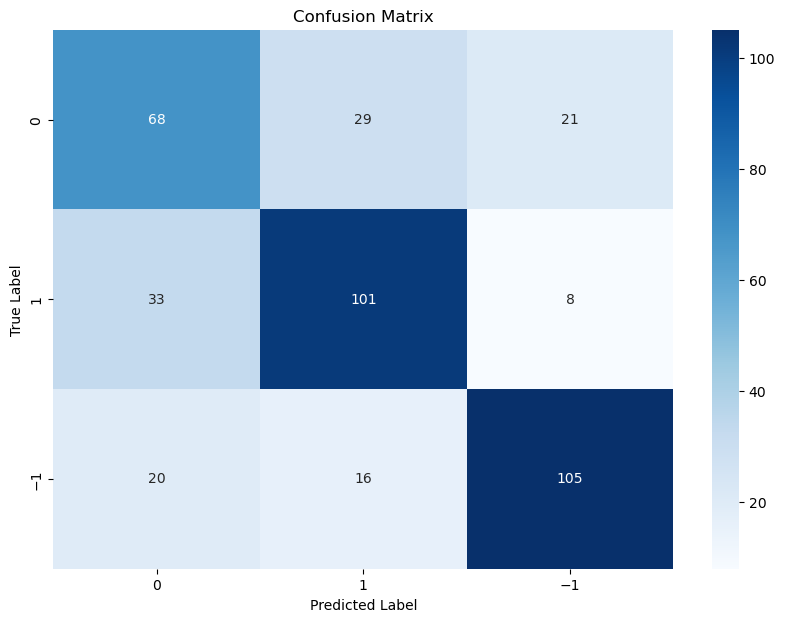

In [153]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# More miscellaneous statistics and other data manipulation stuff

In [154]:
y_train

240      0
1669     0
692     −1
420     −1
1864     0
        ..
1130     1
1294     1
860      0
1459     1
1126     0
Name: sentimentannotation, Length: 1601, dtype: object

In [155]:
df = y_train
# Count the occurrences of each class
class_counts = df.value_counts()

# Print the counts
print(class_counts)

sentimentannotation
0     549
−1    526
1     526
Name: count, dtype: int64


In [156]:
y_test

1394    −1
353      1
1334     1
906      1
1290    −1
        ..
1285     0
914      0
261     −1
535      1
1925     0
Name: sentimentannotation, Length: 401, dtype: object

In [157]:
df2 = y_test
# Count the occurrences of each class
class_counts = df2.value_counts()

# Print the counts
print(class_counts)

sentimentannotation
1     142
−1    141
0     118
Name: count, dtype: int64


In [158]:
# Load the CSV file
df = pd.read_csv('final_corrected_testtestdata.csv')

# Get unique paragrafnummer values
unique_paragrafnummer = df['paragrafnummer'].unique()

# Split the unique paragrafnummer values into the validation set and the rest
nonVal_paragrafnummer, val_paragrafnummer = train_test_split(unique_paragrafnummer, test_size=0.2, random_state=42)

# Create the sets based on paragrafnummer
nonVal_set = df[df['paragrafnummer'].isin(nonVal_paragrafnummer)]
val_set = df[df['paragrafnummer'].isin(val_paragrafnummer)]

# Save the sets to separate CSV files
nonVal_set.to_csv('validationNonSet.csv', index=False)
val_set.to_csv('validation_set.csv', index=False)

print("Training and validation sets created and saved to 'validation_set.csv' and 'validationNonSet.csv'.")

Training and validation sets created and saved to 'validation_set.csv' and 'validationNonSet.csv'.
